### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

In [189]:
#Import Dependancies
from pmdarima.arima import auto_arima
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
plt.style.use(style="seaborn")
%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [190]:
df = pd.read_csv("data/ETH_Daily_Final.csv")
df.head(5)

,Unnamed: 0,Date,Close
0,999,2019-02-15,121.67
1,998,2019-02-16,122.67
2,997,2019-02-17,133.75
3,996,2019-02-18,145.69
4,995,2019-02-19,143.44


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [191]:
df = df[["Close"]].copy()
df.describe()


,Close
count,1000.000000
mean,974.036730
std,1189.295411
min,107.820000
25%,182.322500
50%,273.820000
75%,1777.997500
max,4807.980000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.

### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [192]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 1.6992755055403594
p-value: 0.9981268475231728


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Not stationary as expected so we need to find orders of differencing to make it stationary. We need to check for autocorrelation functioning ACF
#### p

P is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 



In [193]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We plot absolute prices over time and plot the autocorrelation

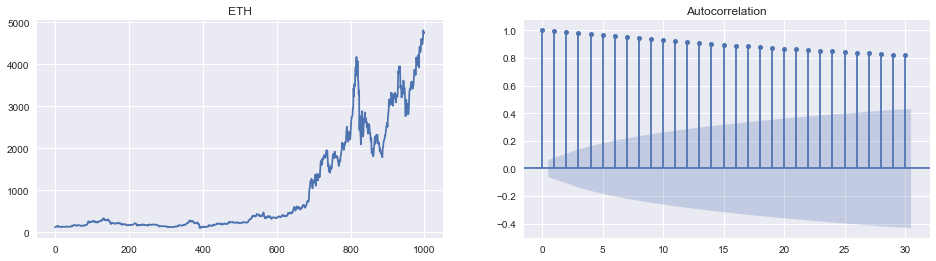

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [194]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df.Close)
ax1.set_title("ETH")
plot_acf(df.Close, ax=ax2);
#slight bug in library so we need to add ; to stop doubling up. 

We plot the first order of difference to get the change around a mean of zero and plot the autocorrelations. 

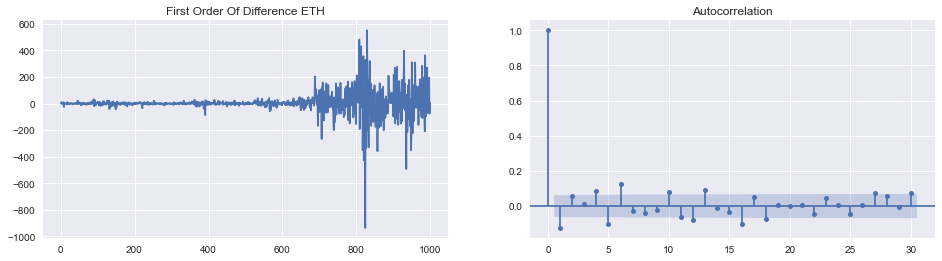

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [195]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("First Order Of Difference ETH")
plot_acf(diff, ax=ax2);

We plot the second order of difference to check the autocorrelation keeping a mind on over differencing. 

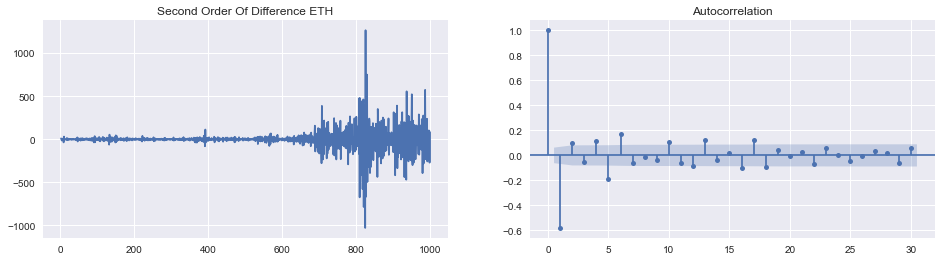

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [196]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Second Order Of Difference ETH")
plot_acf(diff, ax=ax2);

We notice overdifferencing on the Second order so we choose to stick to the first Order of difference. We can use a tool called ndiffs from arima utilities to confirm our visual inspection.  

In [197]:
from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We check our ACF PLOTS with this tool

In [198]:
ndiffs(df.Close, test="adf")

1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It confirms our choice of the first order of difference being the best fit. Therefore D=1 


#### Q

Q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms


Import our dependancies. 

In [199]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

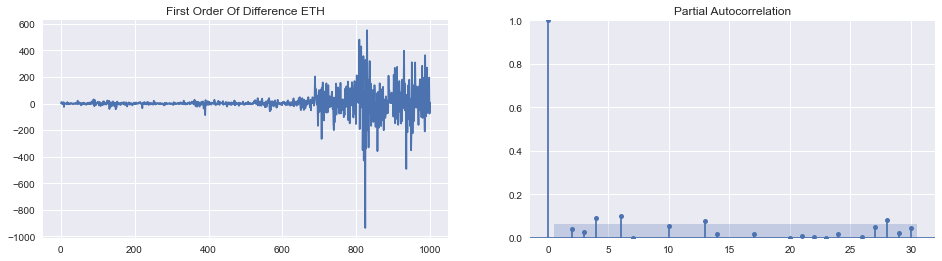

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [200]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("First Order Of Difference ETH")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

We can see that the first PACF above the significance line is 4. So we choose Q=4 for our ARIMA model. 

- p is the order of the AR term = 6

- d is the number of differencing required to make the time series stationary = 1

- q is the order of the MA term = 4

p = 10 would not run. Kept crashing the model so I ran the next best closest signficant thing being 9. 

In [201]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.Close, order=(6, 1, 4))
result = model.fit(disp=0)
print(result.summary())

C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARM

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  999
Model:                 ARIMA(6, 1, 4)   Log Likelihood               -5805.411
Method:                       css-mle   S.D. of innovations             80.809
Date:                Thu, 18 Nov 2021   AIC                          11634.822
Time:                        17:56:25   BIC                          11693.703
Sample:                             1   HQIC                         11657.202
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.6616      2.693      1.731      0.083      -0.617       9.941
ar.L1.D.Close    -0.4955      0.208     -2.383      0.017      -0.903      -0.088
ar.L2.D.Close    -0.8705      0.371     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot Residuals

(array([7.70616435e-06, 0.00000000e+00, 7.70616435e-06, 4.62369861e-05,
        1.15592465e-04, 5.70256162e-04, 6.38841025e-03, 4.31545204e-04,
        8.47678079e-05, 4.62369861e-05]),
 array([-825.24981734, -695.35367765, -565.45753796, -435.56139827,
        -305.66525858, -175.76911889,  -45.87297921,   84.02316048,
         213.91930017,  343.81543986,  473.71157955]),
 <BarContainer object of 10 artists>)

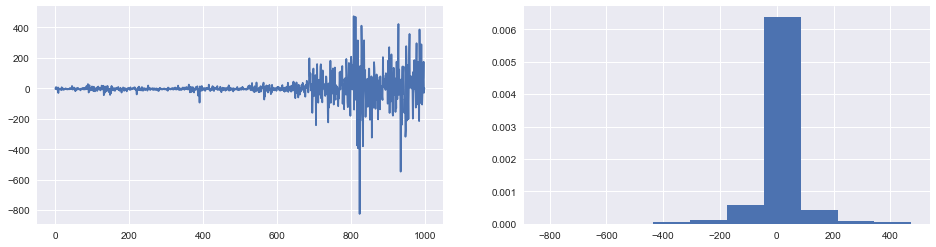

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [202]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

Plot Results of Actual versus Fitted (Training)

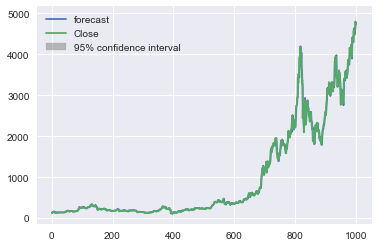

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [203]:
# Actual vs Fitted
result.plot_predict(
    start=1,
    end=1000,
    dynamic=False,
) ;

## Train Test Split

In [204]:
n = int(len(df) * 0.8)
train = df.Close[:n]
test = df.Close[n:]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [205]:
print(len(train))
print(len(test))

800
200


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [206]:
step = 200

model = ARIMA(train, order=(6, 1, 4))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARM

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [207]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  799
Model:                 ARIMA(6, 1, 4)   Log Likelihood               -3944.202
Method:                       css-mle   S.D. of innovations             33.661
Date:                Thu, 18 Nov 2021   AIC                           7912.404
Time:                        17:56:31   BIC                           7968.604
Sample:                             1   HQIC                          7933.995
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.6185      1.167      2.243      0.025       0.330       4.907
ar.L1.D.Close    -1.5041      0.235     -6.406      0.000      -1.964      -1.044
ar.L2.D.Close    -1.4053      0.323     -4.357      0.000      -2.037      -0.773
ar.L3.D.Close    -0.9959      0.297     -3.355      0.001      -1.578      -0.414
ar.L4.D.Close    -0.1573      0.196     -0.803      0.422      -0.541       0.227
ar.L5.D.Close    -0.1652      0.071     -2.342      0.019      -0.303      -0.027
ar.L6.D.Close    -0.1078      0.040     -2.709      0.007      -0.186      -0.030
ma.L1.D.Close     1.5112      0.234      6.452      0.000       1.052       1.970
ma.L2.D.Close     1.5117      0.321      4.713      0.000       0.883       2.140
ma.L3.D.Close     1.0890      0.313      3.480      0.001       0.476       1.702
ma.L4.D.Close     0.1173      0.216      0.543      0.587      -0.306       0.541
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2873           -1.0062j            1.0464           -0.2943
AR.2           -0.2873           +1.0062j            1.0464            0.2943
AR.3           -1.0042           -0.0000j            1.0042           -0.5000
AR.4            1.0447           -1.7430j            2.0321           -0.1641
AR.5            1.0447           +1.7430j            2.0321            0.1641
AR.6           -2.0429           -0.0000j            2.0429           -0.5000
MA.1           -1.0220           -0.0000j            1.0220           -0.5000
MA.2           -0.2157           -1.0093j            1.0321           -0.2835
MA.3           -0.2157           +1.0093j            1.0321            0.2835
MA.4           -7.8318           -0.0000j            7.8318           -0.5000
-----------------------------------------------------------------------------
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Forecast the first Array to check 

In [208]:
fc

array([2198.64291616, 2225.71885465, 2209.28887039, 2232.39656042,
       2238.78491065, 2241.81209041, 2218.93776829, 2252.85832423,
       2241.88733571, 2243.45109609, 2239.11587953, 2266.45151524,
       2242.43003462, 2256.34587185, 2257.52507633, 2270.33692274,
       2249.25289898, 2274.59045674, 2267.42521538, 2273.85491779,
       2264.06410297, 2288.97748049, 2272.04590346, 2283.66579186,
       2280.39189672, 2296.82504926, 2278.71116539, 2298.37845565,
       2292.27731675, 2302.53002425, 2290.55517871, 2312.33269545,
       2299.82866989, 2311.20473183, 2304.7961535 , 2322.3195212 ,
       2307.27050783, 2323.56270053, 2317.20162975, 2329.90843569,
       2317.64447821, 2336.57430825, 2326.58381042, 2338.48953148,
       2330.25627089, 2347.50789954, 2335.01036957, 2349.47233263,
       2342.47792511, 2356.45533196, 2344.83311278, 2361.53869551,
       2352.85346244, 2365.38444159, 2356.34903556, 2372.73560277,
       2362.13662591, 2375.68321079, 2368.14142069, 2382.53893

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Look at the confidence Level

In [209]:
conf

array([[2132.66799307, 2264.61783924],
       [2132.0855122 , 2319.35219709],
       [2090.70951573, 2327.86822505],
       [2095.33221981, 2369.46090104],
       [2088.01882826, 2389.55099304],
       [2079.50097961, 2404.12320121],
       [2042.83460226, 2395.04093432],
       [2065.06967852, 2440.64696994],
       [2044.14377079, 2439.63090062],
       [2035.33188188, 2451.5703103 ],
       [2020.18898296, 2458.04277611],
       [2038.94381961, 2493.95921087],
       [2006.11378899, 2478.74628025],
       [2010.78505943, 2501.90668427],
       [2003.49353532, 2511.55661733],
       [2008.91037776, 2531.76346772],
       [1979.46710769, 2519.03869027],
       [1996.97126708, 2552.2096464 ],
       [1982.69922304, 2552.15120772],
       [1982.05407306, 2565.65576253],
       [1964.62915881, 2563.49904713],
       [1982.93137939, 2595.02358159],
       [1959.40650045, 2584.68530648],
       [1964.2264205 , 2603.10516322],
       [1954.26889447, 2606.51489896],
       [1964.76336517, 26

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Forecast our Lower and Upper Bounds

In [210]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot the Forecast Versus the Actual
Note that it is not accurate over 200 days dues to very bullish movement by ETH. 

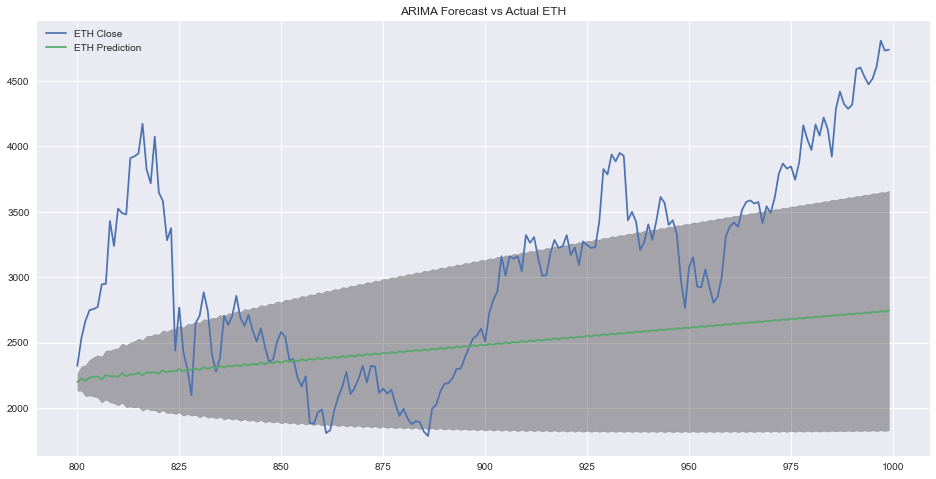

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [211]:
plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="ETH Close")
plt.plot(fc, label="ETH Prediction")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.3)
plt.title("ARIMA Forecast vs Actual ETH")
plt.legend(loc="upper left")

## Start Wranglig and Merging 
 Get the dataframes ready to send to SQL and merge them on their Index.

 Testing Data testdf

In [212]:
testdf = pd.DataFrame(test)
testdf

,Close
800,2320.49
801,2532.60
802,2666.13
803,2748.24
804,2757.04
...,...
995,4518.00
996,4612.59
997,4807.98
998,4732.33


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [213]:
testdf.reset_index().head()

,index,Close
0,800,2320.49
1,801,2532.60
2,802,2666.13
3,803,2748.24
4,804,2757.04


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [214]:
testdf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
testdf

,level_0,index,Close
0,0,800,2320.49
1,1,801,2532.60
2,2,802,2666.13
3,3,803,2748.24
4,4,804,2757.04
...,...,...,...
195,195,995,4518.00
196,196,996,4612.59
197,197,997,4807.98
198,198,998,4732.33


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [215]:
testdf = testdf.drop('index', axis=1)
testdf

,level_0,Close
0,0,2320.49
1,1,2532.60
2,2,2666.13
3,3,2748.24
4,4,2757.04
...,...,...
195,195,4518.00
196,196,4612.59
197,197,4807.98
198,198,4732.33


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [216]:
testdf.reset_index(inplace=True)
testdf

,index,level_0,Close
0,0,0,2320.49
1,1,1,2532.60
2,2,2,2666.13
3,3,3,2748.24
4,4,4,2757.04
...,...,...,...
195,195,195,4518.00
196,196,196,4612.59
197,197,197,4807.98
198,198,198,4732.33


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [217]:
testdf = testdf.drop('level_0', axis=1)
testdf

,index,Close
0,0,2320.49
1,1,2532.60
2,2,2666.13
3,3,2748.24
4,4,2757.04
...,...,...
195,195,4518.00
196,196,4612.59
197,197,4807.98
198,198,4732.33


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Apply Dates to reverse back into time series

In [218]:
dfdt = pd.read_csv("data/Dates.csv")
dfdt

,Dates
0,25/04/2021
1,26/04/2021
2,27/04/2021
3,28/04/2021
4,29/04/2021
...,...
195,6/11/2021
196,7/11/2021
197,8/11/2021
198,9/11/2021


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [219]:
dfdt.reset_index()

,index,Dates
0,0,25/04/2021
1,1,26/04/2021
2,2,27/04/2021
3,3,28/04/2021
4,4,29/04/2021
...,...,...
195,195,6/11/2021
196,196,7/11/2021
197,197,8/11/2021
198,198,9/11/2021


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [220]:
dfdt['Dates'] = pd.to_datetime(dfdt['Dates'],format='%d/%m/%Y')
dfdt


,Dates
0,2021-04-25
1,2021-04-26
2,2021-04-27
3,2021-04-28
4,2021-04-29
...,...
195,2021-11-06
196,2021-11-07
197,2021-11-08
198,2021-11-09


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Wrangle Predicitons 

In [221]:
testfc = pd.DataFrame(fc)
testfc.head()

,0
800,2198.642916
801,2225.718855
802,2209.288870
803,2232.396560
804,2238.784911


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [222]:

testfc = testfc.rename(columns={0:"Predictions"})
testfc.head()

,Predictions
800,2198.642916
801,2225.718855
802,2209.288870
803,2232.396560
804,2238.784911


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [223]:
testfc.reset_index(inplace=True)
testfc = testfc.drop('index', axis=1)
testfc

,Predictions
0,2198.642916
1,2225.718855
2,2209.288870
3,2232.396560
4,2238.784911
...,...
195,2735.474117
196,2731.452928
197,2740.682283
198,2736.721253


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [224]:
#testfc = testfc.rename(columns={0:"index"})
#testfc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [225]:
testfc.reset_index().head()

,index,Predictions
0,0,2198.642916
1,1,2225.718855
2,2,2209.288870
3,3,2232.396560
4,4,2238.784911


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [226]:
#testdf = testdf.drop('level_0', axis=1)
#testdf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Merge Data Frames 

In [227]:
dates_close_df = pd.merge(dfdt, testdf, left_index=True, right_index=True)
dates_close_df

,Dates,index,Close
0,2021-04-25,0,2320.49
1,2021-04-26,1,2532.60
2,2021-04-27,2,2666.13
3,2021-04-28,3,2748.24
4,2021-04-29,4,2757.04
...,...,...,...
195,2021-11-06,195,4518.00
196,2021-11-07,196,4612.59
197,2021-11-08,197,4807.98
198,2021-11-09,198,4732.33


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [228]:
BTC_ARIMA_Results = pd.merge(dates_close_df, testfc, left_index=True, right_index=True)
BTC_ARIMA_Results

,Dates,index,Close,Predictions
0,2021-04-25,0,2320.49,2198.642916
1,2021-04-26,1,2532.60,2225.718855
2,2021-04-27,2,2666.13,2209.288870
3,2021-04-28,3,2748.24,2232.396560
4,2021-04-29,4,2757.04,2238.784911
...,...,...,...,...
195,2021-11-06,195,4518.00,2735.474117
196,2021-11-07,196,4612.59,2731.452928
197,2021-11-08,197,4807.98,2740.682283
198,2021-11-09,198,4732.33,2736.721253


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [229]:
BTC_ARIMA_Results = BTC_ARIMA_Results.drop('index', axis=1)
BTC_ARIMA_Results

,Dates,Close,Predictions
0,2021-04-25,2320.49,2198.642916
1,2021-04-26,2532.60,2225.718855
2,2021-04-27,2666.13,2209.288870
3,2021-04-28,2748.24,2232.396560
4,2021-04-29,2757.04,2238.784911
...,...,...,...
195,2021-11-06,4518.00,2735.474117
196,2021-11-07,4612.59,2731.452928
197,2021-11-08,4807.98,2740.682283
198,2021-11-09,4732.33,2736.721253


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can run some code to try and loop throught and find the optimal p q d

In [230]:
model = auto_arima(
    df.Close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=9,
    max_q=9,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11660.995, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11678.640, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11665.045, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11666.466, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11679.700, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11665.062, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11661.509, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11665.057, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11665.498, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11663.500, Time=0.95 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11662.418, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.713 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>